In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('./data/1-anaylsis_stars.csv')

In [13]:
df.set_index('frame')
df.head()

,Unnamed: 0,frame,bright_w,valence_w,max_w,bright_t,valence_t,max_t,bright_c,valence_c,...,bright_f,valence_f,max_f,bright_s,valence_s,max_s,corrected_focus,val_sq,stars_delta,stars_v_delta
0,0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000082,-5.267204
1,1,2.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000077,-4.529109
2,2,3.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000075,-4.475538
3,3,4.0,0.214669,129.0,3.0,0.011813,30.0,3.0,0.001886,9.0,...,0.000272,6.0,3.0,0.001208,65.0,10.0,0.000272,36.0,0.000074,-3.433871
4,4,5.0,0.214583,134.0,3.0,0.011764,30.0,3.0,0.001940,9.0,...,0.000278,7.0,7.0,0.001183,65.0,9.0,0.000278,49.0,0.000075,-3.000538


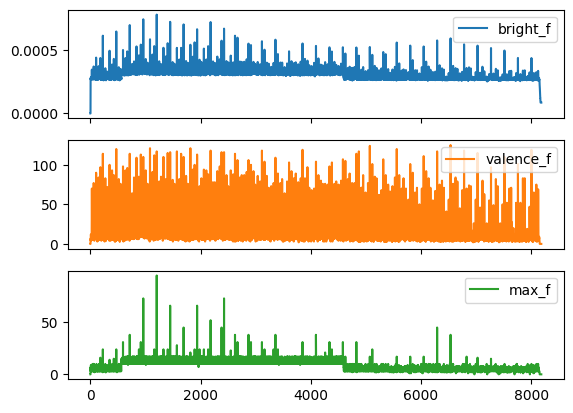

In [6]:
df[["bright_f", "valence_f", "max_f"]].plot(subplots=True)

plt.show()

0.00030240306320410956
0.000326233479435469
3.1960321704594034e-05


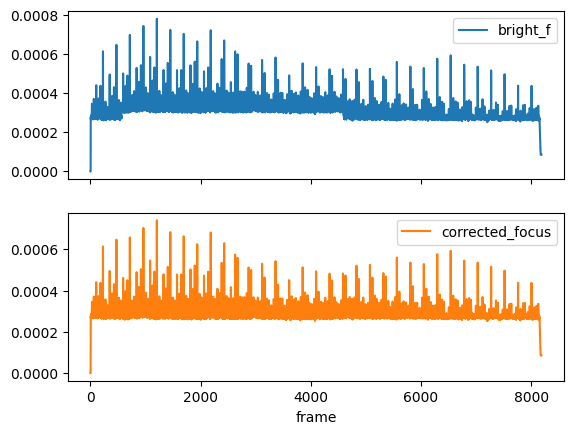

In [7]:
# correct for ambient brightness shift, imagined as aperature shift
# 503-4103
start_frame = 564
end_frame = 4592
print(df['bright_f'].mean())
print(df[start_frame:end_frame]['bright_f'].mean())
print(df[start_frame:end_frame]['bright_f'].std())

focus_correction = df[start_frame:end_frame]['bright_f'].mean() - df['bright_f'].mean()

def correct_focus(row):
    if row['frame'] > start_frame and row['frame'] <= end_frame:
        return row['bright_f'] - (focus_correction+df[start_frame:end_frame]['bright_f'].std()/2)
    else :
        return row['bright_f']

df['corrected_focus'] = df.apply (lambda row: correct_focus(row), axis=1)

# df.head()
df[["frame", "bright_f", "corrected_focus"]].set_index('frame').plot(subplots=True)

plt.show()
    

In [10]:
def get_stars_delta(row):
#     print("\n\n\n============== new row")
    start = row['frame'] - 10
    if start < 6:
        start = 5
    end = row['frame'] + 10
    if end > len(df.index):
        end = len(df.index)
    stars_global_avg = df[['bright_s']].mean()
    stars_local_avg = df[int(start):int(end)][['bright_s']].mean()
    focus_global_avg = df[['corrected_focus']].mean()
    return float(stars_global_avg - stars_local_avg)
df['stars_delta'] = df.apply (lambda row: get_stars_delta(row), axis=1)

In [11]:
def get_stars_v_delta(row):
#     print("\n\n\n============== new row")
    start = row['frame'] - 10
    if start < 6:
        start = 5
    end = row['frame'] + 10
    if end > len(df.index):
        end = len(df.index)
    stars_global_avg = df[['valence_s']].mean()
    stars_local_avg = df[int(start):int(end)][['valence_s']].mean()
    focus_global_avg = df[['valence_s']].mean()
    return float(stars_global_avg - stars_local_avg)
df['stars_v_delta'] = df.apply (lambda row: get_stars_v_delta(row), axis=1)

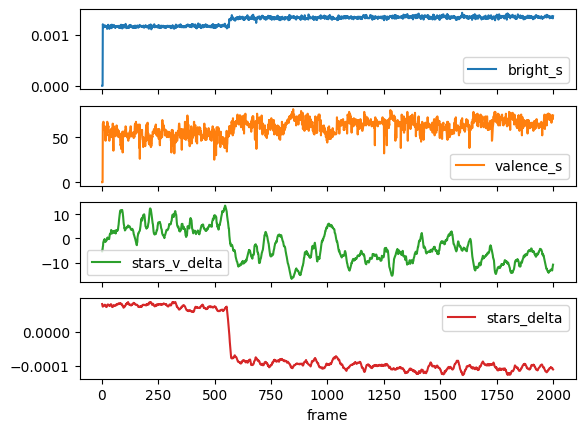

In [12]:
# df.head()
df[0:2000][["frame", "bright_s", "valence_s", "stars_v_delta", "stars_delta"]].set_index('frame').plot(subplots=True)

plt.show()

In [14]:
# Get ratio of average pulse brightness and average start
signal = df['corrected_focus'].mean() + df['corrected_focus'].std() *.56 
print("\nsignal")
print(signal)
avg_bright_f = df[df.corrected_focus > signal]['corrected_focus'].mean()
print("\avg_bright_f")
print(avg_bright_f)

pulse_to_star = float(avg_bright_f) / float(df[['bright_s']].mean())
print("\pulse_to_star")
print(pulse_to_star)


avg_valence_f = df[df.corrected_focus > signal]['valence_f'].mean()
print("\avg_valence_f")
print(avg_valence_f)

pulse_to_star_valence = float(avg_valence_f) / float(df[['valence_s']].mean())
print("\pulse_to_star_valence")
print(pulse_to_star)


signal
0.0003001658500867052
vg_bright_f
0.00035082578916337964
\pulse_to_star
0.28225037996234714
vg_valence_f
63.49107142857143
\pulse_to_star_valence
0.28225037996234714


In [15]:

stars_global_avg = df[['bright_s']].mean()
def correct_by_stars(row):
    focus_global_avg = df[['corrected_focus']].mean()   
    numerator = row['stars_delta'] * focus_global_avg
    focus_delta = float(numerator) / float(stars_global_avg)   
    corrected = row['bright_f'] + focus_delta
    return pulse_to_star * corrected

df['corrected_by_stars'] = df.apply (lambda row: correct_by_stars(row), axis=1)


In [16]:
stars_global_avg = df[['valence_s']].mean()
def valence_correct_by_stars(row):
    focus_global_avg = df[['valence_f']].mean()   
    numerator = row['stars_v_delta'] * focus_global_avg
    focus_delta = float(numerator) / float(stars_global_avg)   
    corrected = row['valence_f'] + focus_delta
    return pulse_to_star_valence * corrected

df['valence_corrected_by_stars'] = df.apply (lambda row: valence_correct_by_stars(row), axis=1)


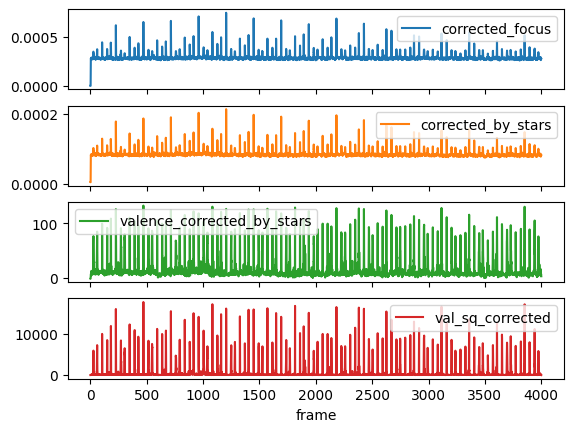

In [17]:
# df.head()

df['val_sq_corrected'] = df["valence_corrected_by_stars"]*df["valence_corrected_by_stars"]
df[0:4000][["frame", "corrected_focus",  "corrected_by_stars", "valence_corrected_by_stars", "val_sq_corrected"]].set_index('frame').plot(subplots=True)

plt.show()

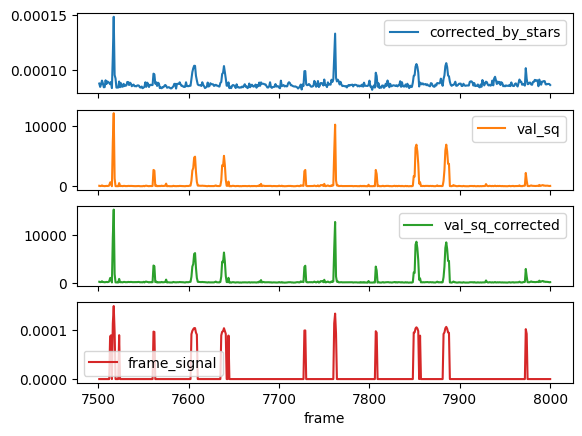

In [18]:

def get_signal(row):
    frame_signal = 0   
    if row['corrected_by_stars'] > df['corrected_by_stars'].mean() + df['corrected_by_stars'].std()    :
        frame_signal = row['corrected_by_stars']
    elif row['val_sq_corrected'] > 800 :
        frame_signal = row['corrected_by_stars']
    
    return frame_signal

df['frame_signal'] = df.apply (lambda row: get_signal(row), axis=1)
df[7500:8000][["frame", "corrected_by_stars", "val_sq", "val_sq_corrected", "frame_signal"]].set_index('frame').plot(subplots=True)

plt.show()

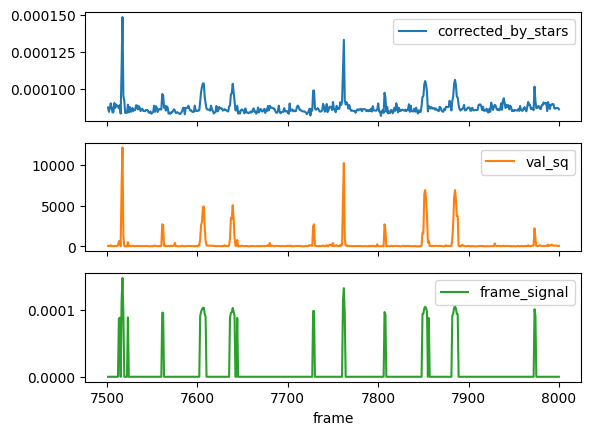

In [20]:
def move_signal(row):
    
    if row['frame_signal'] > df['corrected_by_stars'].mean() + df['corrected_by_stars'].std()    :
        frame_signal = row['corrected_by_stars']
    elif row['val_sq_corrected'] > 800 :
        frame_signal = row['corrected_by_stars']
    
    return frame_signal

df['frame_signal'] = df.apply (lambda row: get_signal(row), axis=1)
df[7500:8000][["frame", "corrected_by_stars", "val_sq", "frame_signal"]].set_index('frame').plot(subplots=True)

plt.show()

In [21]:
df.to_csv('./data/2-corrected_by_stars.csv')
